In [1]:
from gutenbergpy.gutenbergcache import GutenbergCache, GutenbergCacheTypes
import os
import json
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import gensim
from gensim.test.utils import common_texts

# load config
with open('config.json', 'r') as f:
    config = json.load(f)
cwd = os.getcwd()
os.chdir(config['REPODIR'])
import Utils as U
from Corpus import Corpus
os.chdir(cwd)

from collections import Counter, defaultdict
import itertools

from gensim.models import KeyedVectors
from gensim.test.utils import datapath

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")
import pickle as pkl
from sklearn.decomposition import PCA
import nltk

/Users/stephentoner/miniconda3/envs/si699proj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# with open("data_vFinal.pkl", "rb") as infile:
        # data = pkl.load(infile)

data = U.load_file('data_vFF.pkl', 'pkl', config['DATADIR'])

# Just table of contents
# data.pop(3064)

In [3]:
data_df = pd.DataFrame(data)
data_df.head()

,author_id,author_name,book_id,gutenbergbookid,title,text,text_lines,authoryearofbirth,authoryearofdeath,downloads,subjects,topic,Sub_A,Sub_B,Sub_C,str_text_lines,passage_key
0,494,"Lincoln, Abraham",PG8,PG8,Abraham Lincoln's Second Inaugural Address,"[to header material., , ***, , Lincoln's Secon...",17,1809.0,1865.0,25.0,{'United States -- Politics and government -- ...,United States,1861-1865,Politics and government,Presidents,17,PG8_17
1,494,"Lincoln, Abraham",PG9,PG9,Abraham Lincoln's First Inaugural Address,"[I have no lawful right to do so, and I have n...",77,1809.0,1865.0,36.0,{'United States -- Politics and government -- ...,United States,1861-1865,Politics and government,Presidents,77,PG9_77
2,494,"Lincoln, Abraham",PG9,PG9,Abraham Lincoln's First Inaugural Address,[for a minority of their own will secede from ...,277,1809.0,1865.0,36.0,{'United States -- Politics and government -- ...,United States,1861-1865,Politics and government,Presidents,277,PG9_277
3,494,"Lincoln, Abraham",PG9,PG9,Abraham Lincoln's First Inaugural Address,"[in both cases, and a few break over in each. ...",327,1809.0,1865.0,36.0,{'United States -- Politics and government -- ...,United States,1861-1865,Politics and government,Presidents,327,PG9_327
4,494,"Lincoln, Abraham",PG9,PG9,Abraham Lincoln's First Inaugural Address,[There is some difference of opinion whether t...,127,1809.0,1865.0,36.0,{'United States -- Politics and government -- ...,United States,1861-1865,Politics and government,Presidents,127,PG9_127


In [4]:
baby = int(data_df.author_id.nunique() * .15 // 1)

In [5]:
baby_set = set(data_df.author_id.sample(baby))

In [6]:
baby_df = data_df[data_df.author_id.apply(lambda X: X in baby_set)]

In [7]:
baby_df.to_csv('baby_data.csv', index = False)

In [8]:
# data_df = data_df.rename(columns={
#     'title_y' : 'title',
#     'authoryearofbirth_x':'authoryearofbirth',
#     'authoryearofdeath_x':'authoryearofdeath',
#     'downloads_x':'downloads',
#     'subjects_x':'subjects',
#     'Sub_A_x':'topic',
#     'Sub_A_y':'Sub_A',
#     'Sub_B_y':'Sub_B',
#     'Sub_C_y':'Sub_C'
# })

In [9]:
baby = baby_df.to_dict('records')

In [10]:
subsample = data_df.sample(9000, random_state=0)

subject_b = [s for s in subsample['Sub_B']]
other_subject = [s if s != 'Fiction' else subject_b[idx] for idx, s in enumerate(subsample['Sub_A']) ]

subsample['sub'] = other_subject
subsample = subsample[subsample['authoryearofbirth'] > 1750]

<Axes: xlabel='sub'>

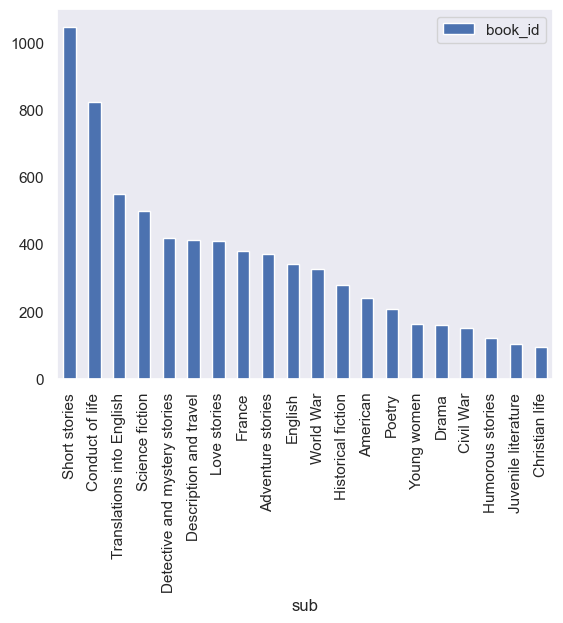

In [11]:
subsample.groupby('sub').agg({'book_id':'count'}).sort_values(by = 'book_id', ascending=False).head(20).plot(kind='bar')

Fetch works for every book

In [12]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [13]:
data_text = [dat['text'] for dat in data]
tokenizer = nltk.RegexpTokenizer(r'\w+')

tokenized_text = [tokenizer.tokenize(' '.join(text)) for text in data_text]
joined_text = [' '.join(text) for text in data_text]


In [14]:
tokenized_text_lower = [[tt.lower() for tt in token_text] for token_text in tokenized_text]

In [ ]:
for idx, d in enumerate(data):
    d['vectors'] = []
    for token in tokenized_text_lower[idx]:
        try:
            d['vectors'].append(model.wv[token])
        except:
            continue
    d['mean_vector'] = np.array([v for v in d['vectors']]).mean(axis = 0)
    if not d['mean_vector'].shape:
        d['mean_vector'] = np.zeros((100,))
    d['key'] = str(d['book_id']) + str(d['text_lines'])

/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_11851/710013910.py:8: RuntimeWarning: Mean of empty slice.
  d['mean_vector'] = np.array([v for v in d['vectors']]).mean(axis = 0)
/Users/stephentoner/miniconda3/envs/si699proj/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
seq_lengths = [len(d['vectors']) for d in baby]

max(seq_lengths)

17

In [ ]:
tokenized_text_lower[0]

['no',
 'i',
 'will',
 'buy',
 'it',
 'of',
 'you',
 'no',
 'phileas',
 'fogg',
 'did',
 'not',
 'betray',
 'the',
 'least',
 'disappointment',
 'but',
 'the',
 'situation',
 'was',
 'a',
 'grave',
 'one',
 'it',
 'was',
 'not',
 'at',
 'new',
 'york',
 'as',
 'at',
 'hong',
 'kong',
 'nor',
 'with',
 'the',
 'captain',
 'of',
 'the',
 'henrietta',
 'as',
 'with',
 'the',
 'captain',
 'of',
 'the',
 'tankadere',
 'up',
 'to',
 'this',
 'time',
 'money',
 'had',
 'smoothed',
 'away',
 'every',
 'obstacle',
 'now',
 'money',
 'failed',
 'still',
 'some',
 'means',
 'must',
 'be',
 'found',
 'to',
 'cross',
 'the',
 'atlantic',
 'on',
 'a',
 'boat',
 'unless',
 'by',
 'balloon',
 'which',
 'would',
 'have',
 'been',
 'venturesome',
 'besides',
 'not',
 'being',
 'capable',
 'of',
 'being',
 'put',
 'in',
 'practice',
 'it',
 'seemed',
 'that',
 'phileas',
 'fogg',
 'had',
 'an',
 'idea',
 'for',
 'he',
 'said',
 'to',
 'the',
 'captain',
 'well',
 'will',
 'you',
 'carry',
 'me',
 'to',
 

In [ ]:
# Worked fine with 'glove-wiki-gigaword-300'

import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [ ]:
for idx, d in enumerate(data):
    d['vectors'] = []
    for token in tokenized_text_lower[idx]:
        try:
            d['vectors'].append(glove_vectors[token])
        except:
            continue
    d['mean_vector'] = np.array([v for v in d['vectors']]).mean(axis = 0)
    if not d['mean_vector'].shape:
        d['mean_vector'] = np.zeros((100,))
    d['key'] = str(d['book_id']) + str(d['text_lines'])
    #  d['subject'] = catalog[catalog['book_id'] == d['book_id']].iloc[0, 9]

In [ ]:
# with open('word_embeddings_data.pkl', 'wb') as f:
#     pkl.dump(baby, f)

NameError: name 'pkl' is not defined

In [ ]:
# mean_vectors = np.array([d['mean_vector'] for d in data if d['mean_vector'].shape and d['subject'] != 'Other'])
mean_vectors = np.array([d['mean_vector'] for d in data if d['mean_vector'].shape])

KeyError: 'mean_vector'

In [ ]:
# ids = [idx for idx, d in enumerate(data) if d['mean_vector'].shape and d['subject'] != 'Other']
ids = [idx for idx, d in enumerate(data) if d['mean_vector'].shape]

In [ ]:
titles = [data[idx]['title'] for idx in ids]
subjects = [data[idx]['sub'] for idx in ids]
# decade = [int(data[idx]['decade']) for idx in ids]
yob = [int(data[idx]['authoryearofbirth']) for idx in ids]
yod = [int(data[idx]['authoryearofdeath']) for idx in ids]
topics = [data[idx]['topic'] for idx in ids]
downloads = [int(data[idx]['downloads']) for idx in ids]
# gender = [1 if data[idx]['gender'] == "F" else 0 for idx in ids]
# penname =[1 if data[idx]['penname'] == "Y" else 0 for idx in ids]
# pn_gend = [str(penname[idx]) + str(gender[idx]) for idx in ids]

In [ ]:
data[9]['text']

['it, when compassion will rise above interest, and the pain that we cause',
 'not only to our fellow-beings, but to any living creature, become',
 'unendurable to us?\'"',
 '',
 '"Dreams, nothing more! Nor are you the first who has followed this',
 'chimera."',
 '',
 '"Well, then, let us dream!" I cried, with more passion than I suspected',
 'myself capable of, "let us dream that this sad reality is no more than',
 'an appearance, a horrible nightmare from which perhaps the human spirit',
 'will one day awaken. And meanwhile so much!--let every man manufacture',
 'his magic world and travel through it, companioned by love and',
 'friendship and virtue, by all those beautiful visions that make life',
 'joyful. For life, Señor Castell, however balanced and physiological it',
 'may be, is a sad and insipid thing when the imagination is not moved to',
 'adorn it. If capricious fortune should ever drag me, like Larra, into',
 'being enamored of a woman who belonged to another" (here my voi

In [ ]:
data[2]

{'author_id': 8634,
 'author_name': 'Willis, Nathaniel Parker',
 'book_id': 'PG47690',
 'gutenbergbookid': 'PG47690',
 'title': 'Canadian Scenery, Volume 1 (of 2)',
 'text': ['defensive position. The New Englanders made every preparation for an',
  'attack on Montreal by land; but the English forces destined for the',
  'cooperation by the St. Lawrence river were required for Portugal, and',
  'thus the Marquis de Vandreuil had time to make better preparations for',
  'defence. The ensuing year (1709) was spent by the English in reducing',
  'Acadia, now Nova Scotia; and when the combined land and sea expedition',
  'against Canada took place in 1711, it was so ill-managed, and the',
  'British fleet, owing to tempestuous weather and ignorance of the coast,',
  'met with so many disasters,—losing by shipwreck in one day (the 22d of',
  'August) eight transports, 884 officers, soldiers, and seamen—that the',
  'expedition returned to Boston, and the restoration of peace between',
  'Fra

In [ ]:
two_dim = mean_vectors



In [ ]:
# two_dim = PCA(random_state =0).fit_transform(mean_vectors)[:1000,]
two_dim = PCA(random_state =0).fit_transform(mean_vectors)


In [ ]:
xPCA = two_dim[:,0]; yPCA = two_dim[:,1]
xPCA.shape

(8178,)

<Axes: >

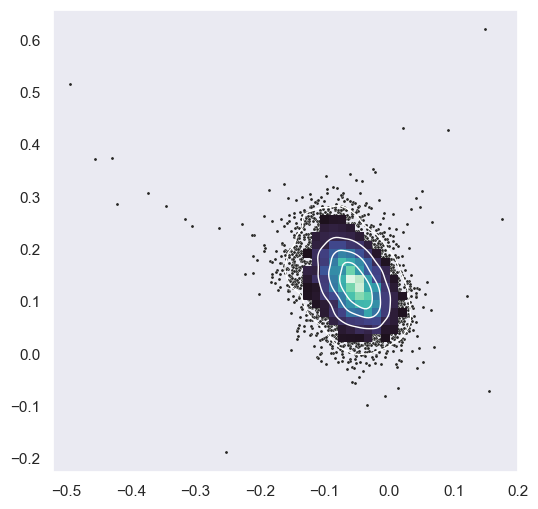

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=xPCA, y=yPCA, s =5, color=".15")
sns.histplot(x=xPCA, y=yPCA, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=xPCA, y=yPCA, levels=5, color="w", linewidths=1)

In [ ]:
import plotly.express as px

def pca_scatterplot_3D(model, user_input=None, color_map=None, sentences = None):

    # three_dim = user_input[:,:3]
    three_dim = PCA(random_state=0).fit_transform(user_input)[:,:3]

    df = pd.DataFrame(three_dim)
    df['Label'] = color_map
    df['sentence'] = sentences

    plot_figure = px.scatter_3d(df, x = 0, y = 1, z = 2, color = 'Label', hover_name = 'sentence', size_max = 2)

    plot_figure.show()

In [ ]:

# For use in the famous literature set
# decade_gender = [int(str(decade[idx]) + str(gender[idx])) for idx in ids]

In [ ]:
from sklearn import mixture

gmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type="full").fit(two_dim)
clusters = gmm.predict(mean_vectors)

/Users/stephentoner/miniconda3/envs/si699proj/lib/python3.9/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [ ]:
# pca_scatterplot_3D(data, user_input = two_dim, color_map = [str(c) for c in clusters], sentences = titles)
pca_scatterplot_3D(data, user_input = two_dim, color_map = clusters, sentences = topics)


In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters = 6).fit(mean_vectors)

cluster_labels = [str(lab) for lab in clustering.labels_]

In [ ]:
extract_data = []

for i, idx in enumerate(ids):
    data[idx]['cluster'] = str(cluster_labels[i])
    extract_data.append(data[idx].copy())



In [ ]:
t = pd.DataFrame(extract_data).groupby(by = ['cluster', 'Sub_A']).agg('count')

In [ ]:
ed = pd.DataFrame(extract_data)

In [ ]:
ed.columns

Index(['author_id', 'author_name', 'book_id', 'gutenbergbookid', 'title',
       'text', 'text_lines', 'authoryearofbirth', 'authoryearofdeath',
       'downloads', 'subjects', 'topic', 'Sub_A', 'Sub_B', 'Sub_C', 'sub',
       'vectors', 'mean_vector', 'key', 'cluster'],
      dtype='object')

In [ ]:
ed[ed['topic']=='Translations into English'].Sub_C.unique()

array(['Church history', nan, 'German fiction', '1860-1904',
       'French fiction', 'Alps', 'Indian drama', 'Avarice',
       'Man-woman relationships', 'Russia', 'Parodies', 'Paris (France)',
       '1828-1910', 'Biographical fiction', 'French',
       'History and criticism', 'German', 'Mythology', 'Germany',
       '1818-1883', '1861-1941', 'Egyptian literature',
       'Eighty Years War', 'Family life', 'Autobiographical fiction',
       'Strindberg', 'Horror tales', 'American poetry', 'Fairy plays',
       'Nuremberg (Germany)', 'Vienna (Austria)',
       'Philosophical anthropology', 'Ghost stories', 'Romances',
       'Chouans', 'Dutch fiction', 'Norwegian drama', 'Palestine',
       'French essays', 'Politics and government',
       'Triangles (Interpersonal relations)', 'Women'], dtype=object)

In [ ]:
t['key'].unstack(0)

cluster,0,1,2,3,4,5
Sub_A,,,,,,
17th century,3.0,NaN,2.0,NaN,NaN,NaN
1861-1865,3.0,NaN,NaN,NaN,NaN,NaN
20th century,22.0,28.0,12.0,NaN,25.0,3.0
Adventure stories,173.0,96.0,72.0,NaN,107.0,6.0
American,127.0,44.0,34.0,2.0,39.0,17.0
Authors,34.0,28.0,2.0,NaN,4.0,1.0
Biography,8.0,NaN,NaN,NaN,NaN,NaN
Boys,26.0,20.0,6.0,NaN,31.0,NaN
Children,13.0,17.0,2.0,NaN,11.0,NaN


In [ ]:
topic_set = ed.topic.unique()
topic_set

array(['Fiction', 'Adventure stories', 'Juvenile literature',
       'Juvenile fiction', 'Translations into English', 'History',
       '19th century', 'Science fiction', 'Great Britain',
       'Short stories', 'Detective and mystery stories',
       'Description and travel', 'American', 'Biography', 'United States',
       'England', 'World War', 'English', 'Poetry', 'Drama',
       'English wit and humor', 'Historical fiction', 'France',
       'Love stories', 'Social life and customs', 'Children',
       'Conduct of life', 'Young women'], dtype=object)